<a href="https://colab.research.google.com/github/RuthKassahun/Melanoma_Classification/blob/main/finetuning_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [ ]:
selected_gpu = 2 # here you select the GPU used (0, 1 or 2)
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    try:
        tf.config.set_visible_devices(gpus[selected_gpu], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs, ", len(logical_gpus),"Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

Num GPUs Available:  3
3 Physical GPUs,  1 Logical GPU


2023-01-14 23:30:27.210739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 23:30:31.174888: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22104 MB memory:  -> device: 2, name: NVIDIA A30, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [2]:
from keras.applications.vgg16 import VGG16

In [3]:
import os
from glob import glob
import cv2
import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.densenet import DenseNet201
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
SIZE = 224
train_images_lbp = []
train_labels_lbp = []
for directory_path in glob.glob("/content/drive/MyDrive/MultiClass_Skin_lesion/train/*"):
    label_lbp_train = directory_path.split("/")[-1]
    label = directory_path.split("/")[-1]
    #print(label_lbp_train)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #print(img_path)
        img1 = cv2.imread(img_path,1) #Reading color images
        img1 = cv2.resize(img1, (SIZE, SIZE)) #Resize images
        arr = np.array(img1) # convert the image to numpy array
        train_images_lbp.append(arr)
        train_labels_lbp.append(label_lbp_train)

train_images_lbp =np.array(train_images_lbp)
trait_labels_lbp =np.array(train_labels_lbp)

In [6]:
from sklearn.utils import class_weight

In [7]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(trait_labels_lbp), y= trait_labels_lbp)

In [ ]:
#train_images_lbp.shape

In [ ]:
#trait_labels_lbp.shape

In [8]:
test_images_lbp = []
test_labels_lbp = [] 
#for directory_path in glob.glob("cell_images/train/*"):
for directory_path in glob.glob("/content/drive/MyDrive/MultiClass_Skin_lesion/val/*"):
    label_lbp_test = directory_path.split("/")[-1]
    label = directory_path.split("/")[-1]
    #print(label_lbp_test)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #print(img_path)
        img2 = cv2.imread(img_path,1) #Reading color images
        img2 = cv2.resize(img2, (SIZE, SIZE)) #Resize images
        arr = np.array(img2) # convert the image to numpy array
        test_images_lbp.append(arr)
        test_labels_lbp.append(label_lbp_test)

test_images_lbp =np.array(test_images_lbp)
test_labels_lbp =np.array(test_labels_lbp)

In [9]:
test_images_lbp.shape

(1270, 224, 224, 3)

In [10]:
X_train, y_train , X_val, y_val = train_images_lbp,trait_labels_lbp,test_images_lbp,test_labels_lbp

In [ ]:
#X_train.shape

In [ ]:
#X_val.shape

In [ ]:
#y_train.shape

In [ ]:
#y_val.shape

In [11]:
from keras.utils.np_utils import to_categorical

In [12]:
le = preprocessing.LabelEncoder()
le.fit(y_val)
y_val = le.transform(y_val)
le.fit(y_train)
y_train = le.transform(y_train)

In [13]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
#y_val.shape

In [ ]:
#y_train.shape

In [14]:
pre_trained_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#pre_trained_model = DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")


74836368/74836368 [==============================] - 4s 0us/step


In [15]:
for layer in pre_trained_model.layers:
    #print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

#print(len(pre_trained_model.layers))

In [16]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 512)


In [18]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(3, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)


In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00


In [ ]:
#model.summary()


In [21]:
train_datagen = ImageDataGenerator(rotation_range=45, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [ ]:
# batch_size = 32
# epochs = 5
# history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
#                               verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
#                               validation_steps=(X_val.shape[0] // batch_size))

In [ ]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()

In [37]:
#pre_trained_model.layers[15].name


'block5_conv1'

In [38]:
# for layer in pre_trained_model.layers[15:]:
#     layer.trainable = True

In [22]:
model = Model(pre_trained_model.input, x)

In [23]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [25]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.0001, cooldown=2)

In [26]:
batch_size = 64
epochs = 50
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs,  validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

<ipython-input-26-ecaf99983759>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/50
79/79 [==============================] - 68s 698ms/step - loss: 12.1239 - acc: 0.5438 - val_loss: 4.6861 - val_acc: 0.6924 - lr: 1.0000e-04
Epoch 2/50
79/79 [==============================] - 52s 650ms/step - loss: 7.8416 - acc: 0.6116 - val_loss: 3.3612 - val_acc: 0.7220 - lr: 1.0000e-04
Epoch 3/50
79/79 [==============================] - 53s 670ms/step - loss: 5.6222 - acc: 0.6433 - val_loss: 2.7967 - val_acc: 0.7270 - lr: 1.0000e-04
Epoch 4/50
79/79 [==============================] - 52s 653ms/step - loss: 4.4426 - acc: 0.6471 - val_loss: 2.1647 - val_acc: 0.7138 - lr: 1.0000e-04
Epoch 5/50
79/79 [==============================] - 52s 658ms/step - loss: 3.4067 - acc: 0.6618 - val_loss: 1.6813 - val_acc: 0.7204 - lr: 1.0000e-04
Epoch 6/50
79/79 [==============================] - 52s 650ms/step - loss: 2.6612 - acc: 0.6734 - val_loss: 1.6442 - val_acc: 0.7336 - lr: 1.0000e-04
Epoch 7/50
79/79 [==============================] - 52s 653ms/step - loss: 2.2716 - acc: 0.6687 - v

In [27]:
!pip install pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [28]:
import pickle

In [29]:
pickle.dump(model, open('model_multi.sav', 'wb'))

In [30]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

40/40 [==============================] - 9s 214ms/step - loss: 0.5687 - acc: 0.7811
Validation: accuracy = 0.781102  ;  loss_v = 0.568734


In [31]:
prediction = model.predict(X_val)

40/40 [==============================] - 6s 162ms/step


In [32]:
y_pred = np.argmax(prediction, axis=1)

In [33]:
np.unique(y_pred)

array([0, 1, 2])

In [34]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels_lbp)
test_labels_encoded = le.transform(test_labels_lbp)

In [35]:
np.unique(test_labels_encoded)

array([0, 1, 2])

In [36]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_pred, test_labels_encoded)
print(kappa)

0.5914924537296301


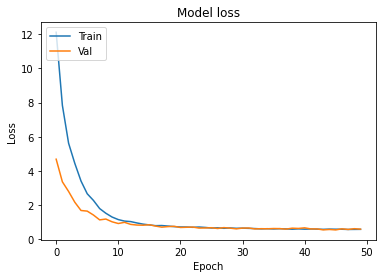

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

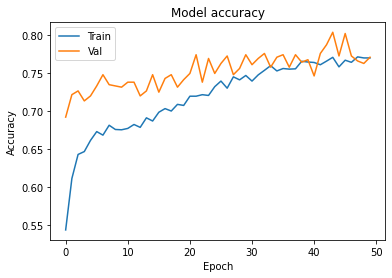

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
